### Carga Corpus

In [ ]:
!pip3 install gensim


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import words
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


In [2]:
! pip3 install -q kaggle



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
! kaggle datasets download -d arushchillar/disneyland-reviews
! unzip disneyland-reviews.zip


 90%|██████████████████████████████████▏   | 10.0M/11.1M [00:01<00:00, 10.5MB/s]
100%|██████████████████████████████████████| 11.1M/11.1M [00:01<00:00, 7.06MB/s]
Archive:  disneyland-reviews.zip
  inflating: DisneylandReviews.csv   


In [5]:
import pandas as pd
df = pd.read_csv("./DisneylandReviews.csv", encoding="ISO-8859-1")


A fines de generar un modelo de Sentiment Analysis, generaremos una variable Target con el sentimiento de cada review en base a la variable rating de la siguiente manera:
1. Positive: Reseñas con puntaje 4 o 5
2. Neutral: Reseñas con puntaje 3
3. Negative: Reseñas con puntaje 1 y 2

In [6]:
#Genero columna target
def Target(row):
    sentiment = "positive"
    if int(row["Rating"]) == 3:
        sentiment = "neutral"
    elif int(row["Rating"]) < 3:
        sentiment = "negative"
    return sentiment

df["target"] = df.apply(Target, axis=1)
print(df.groupby(['target'])['target'].count())


target
negative     3626
neutral      5109
positive    33921
Name: target, dtype: int64


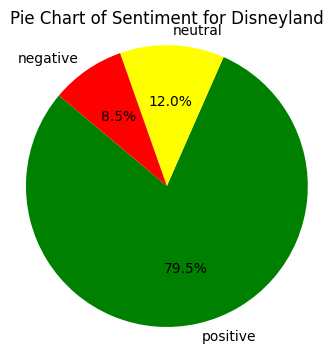

In [7]:
import matplotlib.pyplot as plt

target_counts = df['target'].value_counts()

colors = {'positive': 'green', 'neutral': 'yellow', 'negative': 'red'}

plt.figure(figsize=(4, 4))
plt.pie(target_counts, labels=target_counts.index, colors=[colors[sentiment] for sentiment in target_counts.index], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Pie Chart of Sentiment for Disneyland')
plt.show()


### Análisis Descriptivo

Bag of Words Binarizado: asigna un 1 a todas las palabras del corpus que estén presentes en el documento

Regresión Logística para evaluar qué palabras son las más significativas por categoría

In [8]:
corpus = df["Review_Text"].tolist()


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = df['Review_Text'].tolist()

vectorizer = CountVectorizer(binary=True)
matriz_bow = vectorizer.fit_transform(corpus)

# Convierte la matriz BoW en un diccionario de BoW binarizado para cada documento
diccionarios_bin = [dict(zip(vectorizer.get_feature_names_out(), row.toarray()[0])) for row in matriz_bow]
print(diccionarios_bin[0])


: 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rlog = LogisticRegression()
X = diccionarios_bin
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
rlog.fit(X_train, y_train)

pred = rlog.predict(X_test)

accuracy = accuracy_score(y_test, pred)
reporte_clasificacion = classification_report(y_test, pred)
matriz_confusion = confusion_matrix(y_test, pred)

print(f"Precisión: {accuracy}")
print(reporte_clasificacion)
print(matriz_confusion)


In [ ]:
rlog.fit(X, y)
betas = rlog.coef_
print(betas)


Bag of Words con todo el corpus: Devuelve frecuencia de aparición de cada palabra

In [ ]:
! pip3 install transformers nltk


In [9]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srosati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
from transformers import AutoTokenizer
from nltk.corpus import stopwords
from collections import defaultdict

import string

stop_words = set(stopwords.words('english'))
tokenizer = AutoTokenizer.from_pretrained("gpt2")

def get_word_freqs(corpus):
    word_freqs = defaultdict(int)

    for text in corpus:
        text = text.translate(str.maketrans('', '', string.punctuation))
        filtered_text = [word.lower() for word in text.split(" ") if word.lower() not in stop_words]
        filtered_text = " ".join(filtered_text)
        words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(filtered_text)
        new_words = [word for word, _ in words_with_offsets]
        for word in new_words:
            word = word.lstrip("Ġ")
            if word != "":
                word_freqs[word] += 1
    
    return word_freqs


/Users/srosati/University/NLP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
word_freqs = get_word_freqs(corpus)
print(sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:15])


[('park', 44309), ('disney', 35973), ('rides', 34295), ('disneyland', 32622), ('time', 29219), ('day', 28145), ('get', 22963), ('go', 20091), ('one', 19081), ('ride', 17661), ('great', 16305), ('would', 14591), ('kids', 14135), ('food', 14129), ('place', 13367)]


In [ ]:
! pip install wordcloud matplotlib


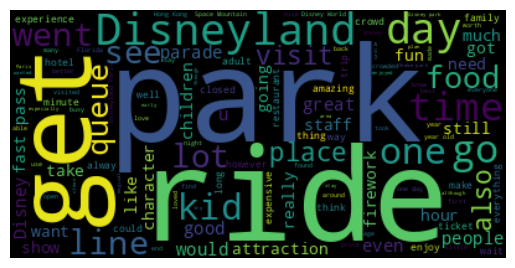

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(corpus, filtered_words = []):
    filtered_words.extend(stop_words)
    text = "\n".join(corpus)

    wordcloud = WordCloud(stopwords=set(filtered_words)).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(corpus)


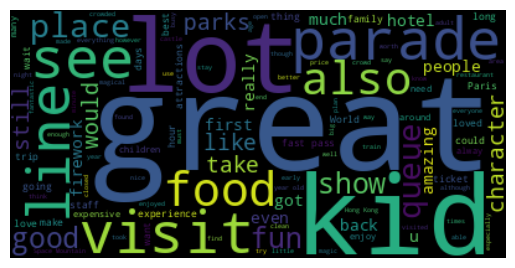

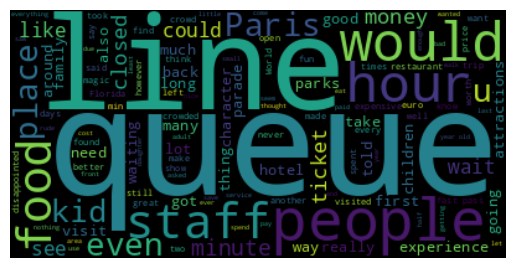

In [13]:
common_words = ["DISNEYLAND", "DISNEY", "RIDE", "RIDES", "PARK", "DAY", "GET", "ATTRACTION", "WENT", "GO", "ONE", "TIME"]
positive_corpus = df[df['target'] == 'positive']['Review_Text'].tolist()
plot_word_cloud(positive_corpus, common_words)

# neutral_corpus = df[df['target'] == 'neutral']['Review_Text'].tolist()
# plot_word_cloud(neutral_corpus, common_words)

negative_corpus = df[df['target'] == 'negative']['Review_Text'].tolist()
plot_word_cloud(negative_corpus, common_words)


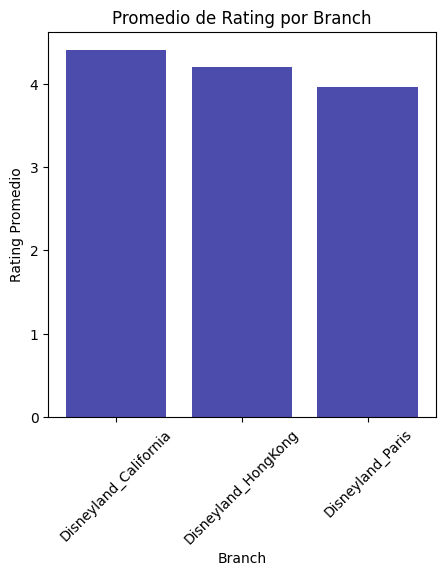

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

branch_ratings_avg = df.groupby('Branch')['Rating'].mean()

# Obtener las etiquetas de las sucursales
branch_labels = branch_ratings_avg.index

# Obtener los valores promedio de Rating
ratings_avg_values = branch_ratings_avg.values

# Crear un gráfico de barras
plt.figure(figsize=(5, 5))
plt.bar(branch_labels, ratings_avg_values, color='darkblue', alpha=0.7)
plt.xlabel('Branch')
plt.ylabel('Rating Promedio')
plt.title('Promedio de Rating por Branch')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()


/var/folders/d8/y6xtk4kx5r7ctcr0s418mrz80000gn/T/ipykernel_71121/977167236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disneyParis["target"] = df.apply(Target, axis=1)


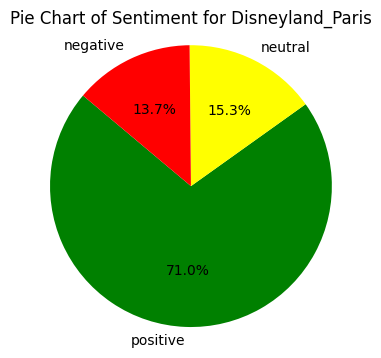

In [15]:
disneyParis = df[df['Branch'] == 'Disneyland_Paris']

disneyParis["target"] = df.apply(Target, axis=1)

target_counts_paris = disneyParis['target'].value_counts()


colors = ['green', 'yellow', 'red']

# Crear el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(target_counts_paris, labels=target_counts_paris.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for Disneyland_Paris')
plt.show()


/var/folders/d8/y6xtk4kx5r7ctcr0s418mrz80000gn/T/ipykernel_71121/2532616550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DisneyHongKong["target"] = df.apply(Target, axis=1)


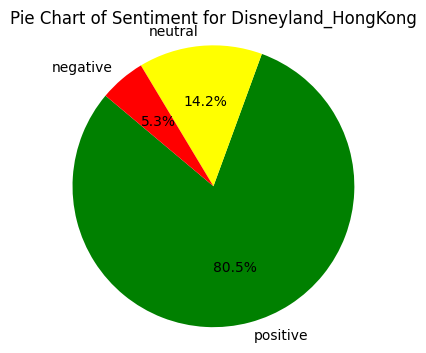

In [16]:
DisneyHongKong = df[df['Branch'] == 'Disneyland_HongKong']

DisneyHongKong["target"] = df.apply(Target, axis=1)

target_counts_hongkong = DisneyHongKong['target'].value_counts()


colors = ['green', 'yellow', 'red']

# Crear el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(target_counts_hongkong, labels=target_counts_hongkong.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for Disneyland_HongKong')
plt.show()


/var/folders/d8/y6xtk4kx5r7ctcr0s418mrz80000gn/T/ipykernel_71121/1374310134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DisneyCalifornia["target"] = df.apply(Target, axis=1)


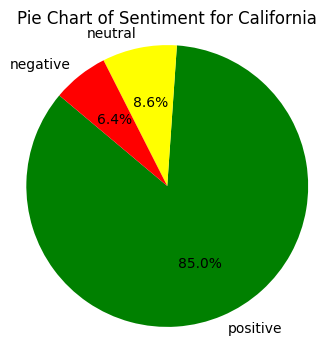

In [17]:
DisneyCalifornia = df[df['Branch'] == 'Disneyland_California']

DisneyCalifornia["target"] = df.apply(Target, axis=1)

target_counts_california = DisneyCalifornia['target'].value_counts()


colors = ['green', 'yellow', 'red']

# Crear el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(target_counts_california, labels=target_counts_california.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for California')
plt.show()


/var/folders/d8/y6xtk4kx5r7ctcr0s418mrz80000gn/T/ipykernel_71121/599365551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DisneyHongKong["target"] = df.apply(Target, axis=1)


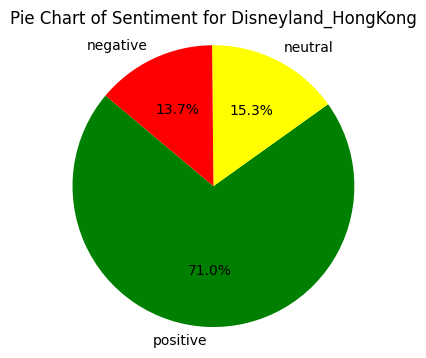

In [18]:
DisneyHongKong = df[df['Branch'] == 'Disneyland_Paris']

DisneyHongKong["target"] = df.apply(Target, axis=1)

target_counts_hongkong = DisneyHongKong['target'].value_counts()


colors = ['green', 'yellow', 'red']

# Crear el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(target_counts_hongkong, labels=target_counts_hongkong.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for Disneyland_HongKong')
plt.show()


Byte-Pair Encoding: Amplía el vocabulario con las agrupaciones de tokens más comunes

### Vocabulario

In [19]:
vocab = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in vocab:
            vocab.append(letter)
vocab.sort()

print(vocab)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [20]:
#Recibe todos los caracteres separados de las palabras de los documentos, los empareja y calcula la frecuencia de los emparejamientos
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

splits = {word: [c for c in word] for word in word_freqs.keys()}
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break


('y', 'o'): 16835
('o', 'u'): 130405
('u', 'v'): 1989
('v', 'e'): 125767
('e', 'v'): 54229
('e', 'r'): 231690


In [21]:
#Muestra el par más repetido
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)


('i', 'n') 286933


In [22]:
#encuentra en las palabras los pares indicados y los agrupa
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

splits = merge_pair("i", "n", splits)

for i, key in enumerate(splits.keys()):
    print(f"{key}: {splits[key]}")
    if i >= 5:
        break


youve: ['y', 'o', 'u', 'v', 'e']
ever: ['e', 'v', 'e', 'r']
disneyland: ['d', 'i', 's', 'n', 'e', 'y', 'l', 'a', 'n', 'd']
anywhere: ['a', 'n', 'y', 'w', 'h', 'e', 'r', 'e']
youll: ['y', 'o', 'u', 'l', 'l']
find: ['f', 'in', 'd']


In [23]:
#muestra los pares más repetidos
merges = {("i", "n"): "in"}
vocab.append("in")

vocab_size = 100 #setea el máximo de pares a insertar hasta que el vocab alcance dicho tamaño

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

print(merges)


{('i', 'n'): 'in', ('e', 'r'): 'er', ('a', 'r'): 'ar', ('e', 's'): 'es', ('e', 'n'): 'en', ('a', 'n'): 'an', ('o', 'n'): 'on', ('e', 'd'): 'ed', ('s', 't'): 'st', ('in', 'g'): 'ing', ('i', 's'): 'is', ('a', 'l'): 'al', ('o', 'u'): 'ou', ('r', 'e'): 're', ('r', 'i'): 'ri', ('t', 'i'): 'ti', ('t', 'h'): 'th', ('n', 'e'): 'ne', ('p', 'ar'): 'par', ('o', 'r'): 'or', ('a', 'y'): 'ay', ('l', 'y'): 'ly', ('l', 'e'): 'le', ('a', 't'): 'at', ('i', 't'): 'it', ('d', 'is'): 'dis', ('a', 'c'): 'ac', ('c', 'h'): 'ch', ('m', 'e'): 'me', ('ne', 'y'): 'ney', ('dis', 'ney'): 'disney', ('e', 't'): 'et', ('l', 'o'): 'lo', ('l', 'd'): 'ld', ('ri', 'd'): 'rid', ('an', 'd'): 'and', ('par', 'k'): 'park', ('a', 's'): 'as', ('i', 'c'): 'ic', ('en', 't'): 'ent', ('h', 'o'): 'ho', ('a', 'd'): 'ad', ('g', 'o'): 'go', ('s', 'e'): 'se', ('i', 'd'): 'id', ('g', 'h'): 'gh', ('v', 'er'): 'ver', ('e', 'l'): 'el', ('l', 'and'): 'land', ('r', 'o'): 'ro', ('d', 'ay'): 'day', ('a', 'st'): 'ast', ('m', 'a'): 'ma', ('k', 'e'

In [ ]:
print(vocab)


TF-IDF: Devuelve el "peso" de cada palabra dentro de cada documento

In [ ]:
! pip install scikit-learn


In [ ]:
#Genera peso para cada palabra de cada documento
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(1,1))
bow = vect.fit_transform(df['Review_Text'])
total_features = len(vect.vocabulary_)

print(bow[0]) #muestro pesos de palabras del documento 0


In [ ]:
#muestro orden de palabras con mayor peso del documento 0
print(sorted((bow[0,doc] for doc in range(total_features)), reverse=True))


In [ ]:
print(bow[0]==0.40736440254022876) #la palabra con el mayor peso del doc 0 es la 15187


In [ ]:
vect.get_feature_names_out()[15187]


In [ ]:
df["Review_Text"][0]


### Análisis Predictivo

Topic Modelling con LDA

Modelo Preentrenado roBERTa

In [ ]:
!pip3 install transformers
!pip3 install torch torchvision


In [54]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(roberta, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(roberta)
# config = AutoConfig.from_pretrained("roberta-base")
# model = RobertaModel.from_pretrained("roberta-base", config=config)

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)


In [80]:
from transformers import BertTokenizer, BertForSequenceClassification

roberta = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(roberta, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(roberta)

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
!pip3 install scipy


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [82]:
from scipy.special import softmax
labels = ['negative', 'neutral', 'positive']

for i in range(len(corpus[:10])):
    tokens = tokenizer(corpus[i], padding=True, truncation=True, return_tensors="pt")
    outputs = model(**tokens)
    scores = outputs[0][0].detach().numpy()
    scores = softmax(scores)

    max_score_index = scores.argmax()
    
    print(df['target'][i], labels[max_score_index])


positive negative
positive negative
positive negative
positive negative
positive negative
neutral positive
positive negative
neutral negative
negative positive
positive positive


In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(corpus, df['target'], test_size=0.2, random_state=22)


In [85]:
# Create torch dataset
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])
    
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_test)


  0%|          | 0/12798 [04:17<?, ?it/s]


In [86]:
!pip3 install accelerate -U


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [87]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import numpy as np

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)



In [88]:
trainer.train()


  0%|          | 0/12798 [00:00<?, ?it/s]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().